# Sleep spindles detection

## 1- Détection de spindles

### Importations

Commençons par importer les librairies utilisées.

In [1]:
import numpy as np 
import scipy.signal as sg
import matplotlib.pyplot as plt
import h5py
import importlib
import myAlgos

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Importons maintenant les données EEG.

In [2]:
importlib.reload(myAlgos)
data_spindles = h5py.File('data_spindles.h5')    
n_days = len(data_spindles) # n=7
eeg_signals = [None] * n_days
hypnograms = [None] * n_days
hypnograms_long = [None] * n_days

for i in range(n_days):
    path = 'day_' + str(i) + '/'
    eeg_signals[i] = data_spindles[path + 'eeg_signal']
    hypnograms[i] = data_spindles[path + 'hypnogram']

# Cela permet de recuperer un stade de sommeil facilement :
for i in range(n_days):
    hypnograms_long[i] = np.empty(len(eeg_signals[i]))
    hypnograms_long[i][:] = np.nan
    len_cast = int(len(eeg_signals[i])/len(hypnograms[i]))
    for j in range(len(hypnograms[i])):
        hypnograms_long[i][j*len_cast:(j+1)*len_cast] = hypnograms[i][j]
    hypnograms_long[i][np.where(np.isnan(hypnograms_long[i]))] = 0
# Ainsi, on peut obtenir simplement : stade de sommeil du point eeg_signals[i][124] <=> hypnograms_long[124] 

for i in range(n_days):
    l = len(eeg_signals[i])
    t = myAlgos.pointsToTime(l)
    print("jour %s : %s points | %sh %sm %ss" %(i, l, t[0], t[1], t[2]))

jour 0 : 7329225 points | 8h 8m 36s
jour 1 : 7785250 points | 8h 39m 1s
jour 2 : 6761103 points | 7h 30m 44s
jour 3 : 7024938 points | 7h 48m 19s
jour 4 : 7031288 points | 7h 48m 45s
jour 5 : 7744777 points | 8h 36m 19s
jour 6 : 7913879 points | 8h 47m 35s


Le signal EEG de chaque jour est accessible par :  ```eeg_signals[jour]```

L'hypnogramme d'un point en particulier peut être obtenu par : ```hypnograms_long[jour][point]```.

Affichons à titre d'exemple l'EEG du jour 3 superposé à l'hypnogramme.

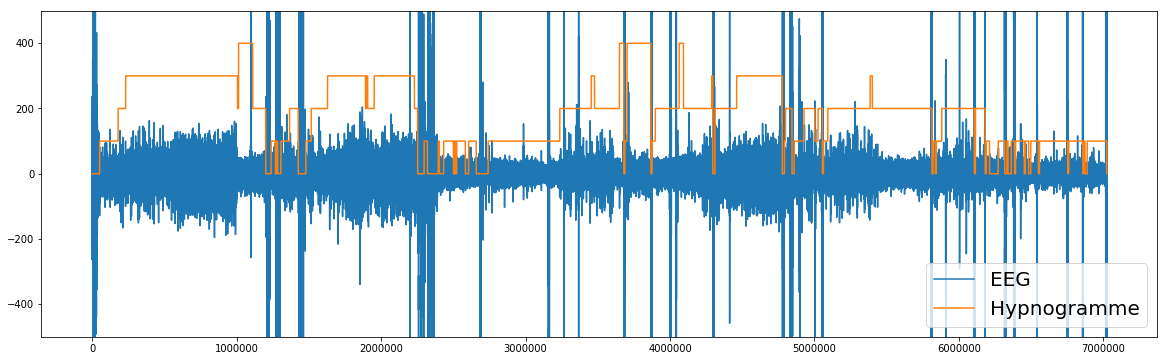

In [30]:
plt.clf()
plt.figure(figsize = (20,6))
plt.plot(eeg_signals[3])
plt.plot(hypnograms_long[3] * 100)
plt.legend(['EEG', 'Hypnogramme'], fontsize = 20, loc = 4)
plt.ylim(-500,500)
plt.show()

On remarque au premier abord la présence d'artefacts de très grande amplitude qu'on pourra facilement détecter avec un seuil.

### Filtre passe-bande

Filtrons le signal entre 11Hz et 15Hz avec un passe-bande Butterworth d'ordre 5.

In [4]:
Fs = 250
b,a = sg.butter(5,(11/Fs, 15/Fs),'bandpass')
eeg_signals_filt = [None] * n_days
for i in range(n_days):
    eeg_signals_filt[i] = sg.filtfilt(b,a,eeg_signals[i])

C:\ProgramData\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


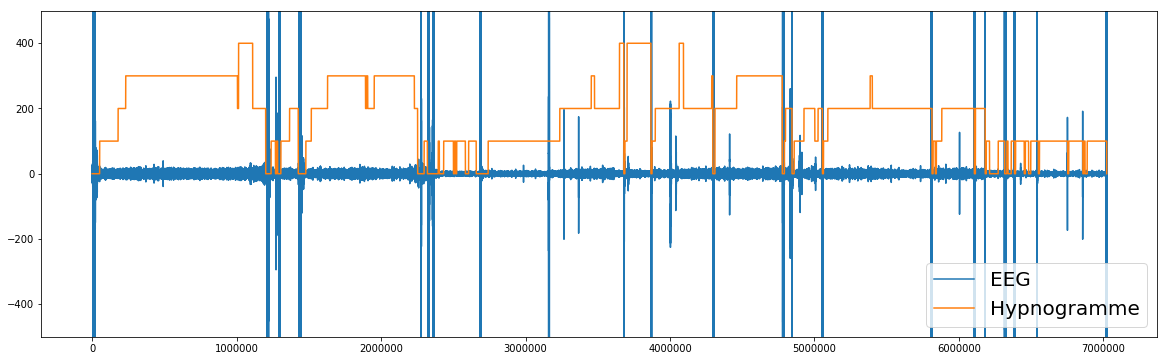

In [29]:
plt.clf()
plt.figure(figsize = (20,6))
plt.plot(eeg_signals_filt[3])
plt.plot(hypnograms_long[3] * 100)
plt.legend(['EEG', 'Hypnogramme'], fontsize = 20, loc = 4)
plt.ylim(-500,500)
plt.show()

Regardons à quoi ressemble le signal filtré de plus près en choisissant arbitrairement quelques points.

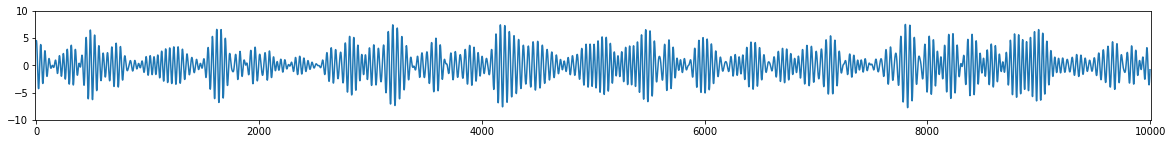

In [6]:
plt.clf()
plt.figure(figsize = (20,2))
plt.plot(eeg_signals_filt[3][2990000 : 3000000])
plt.xlim(-10,10010)
plt.ylim(-10,10)
plt.show()

Sans surprise, on observe un signal avec des fréquences autour de 13Hz. En l'occurrence, c'est un signal pris pendant le sommeil léger N1.

### Organisation du signal en epochs

Divisons le signal en epochs de 5 secondes.

In [7]:
n_pts_epochs = 1250
# Il faut rendre le nombre de pts du signal divisible par la taille d'un epoch
for i in range(n_days):
    reste = len(eeg_signals[i])%n_pts_epochs
    eeg_signals[i] = eeg_signals[i][reste:]
    eeg_signals_filt[i] = eeg_signals_filt[i][reste:]
    hypnograms_long[i] = hypnograms_long[i][reste:]
    
def signal_to_epochs(eeg_data):
    epochs = [None] * n_days
    # n epochs, 0.5s/epoch --> (n, 125)
    for i in range(n_days):
        n_epochs = int(len(eeg_data[i])/n_pts_epochs)
        epochs[i] = np.reshape(eeg_data[i], (n_epochs, n_pts_epochs))
    return epochs

epochs = signal_to_epochs(eeg_signals)
epochs_filt = signal_to_epochs(eeg_signals_filt)
hypno_epochs = signal_to_epochs(hypnograms_long)

Exemple pour acceder à l'epoch 10 du jour 2 : ```epochs[2][10]```.

On peut récupérer l'hypnograme d'un epoch par : ```hypno_epoch[jour][epoch]```.

### Détection des spindles

Commençons par retirer les points à très haute amplitude (ainsi qu'une seconde avant et après au cas où) représentant des artefacts. J'ai choisi de remplacer ces points par ```numpy.NaN```.

In [8]:
eeg_signals_filt_nan = [None] * n_days
for i in range(7):
    #Enlever les valeurs excessivement grandes
    amp_excess = np.where(np.abs(eeg_signals_filt[i]) > 80)[0]
    eeg_signals_filt_nan[i] = np.copy(eeg_signals_filt[i])
    rem_len = 375 #On enlève 1.5s à droite et à gauche
    for j in range(len(amp_excess)):
        #Si on est pas aux limites
        if amp_excess[j] > rem_len and amp_excess[j] + rem_len < len(eeg_signals_filt_nan[i]):
            eeg_signals_filt_nan[i][amp_excess[j] - rem_len :  amp_excess[j] + rem_len] = np.NaN
        #Sinon
        elif amp_excess[j] < rem_len:
            eeg_signals_filt_nan[i][:amp_excess[j] + rem_len] = np.NaN
        elif amp_excess[j] + rem_len > len(eeg_signals_filt_nan[i]):
            eeg_signals_filt_nan[i][amp_excess[j]:] = np.NaN
    
epochs_filt_nan = signal_to_epochs(eeg_signals_filt_nan)

#### Le déroulement de l'algorithme est le suivant :

Je pars de l'idée qu'un spindle devrait être de plus haute amplitude que le signal autour de lui.

J'applique donc un seuil partiellement arbitraire, basé sur la répartition de l'amplitude d'un sleep spindle constatée dans l'article *"Characterizing sleep spindles in 11,630 individuals from the National Sleep Research Resource (S. M. Purcell et. al.)"*, qui montre qu'un spindle a une amplitude avoisinnant les 20 microvolts.

Prenons l'exemple de l'epoch 132 du jour 3 :
<img src="algo_explanation.png" alt="algo_exp" style="width: 700px;"/>

On s'attarde alors sur la nouvelle fenêtre sur laquelle on applique une détection de crêtes.

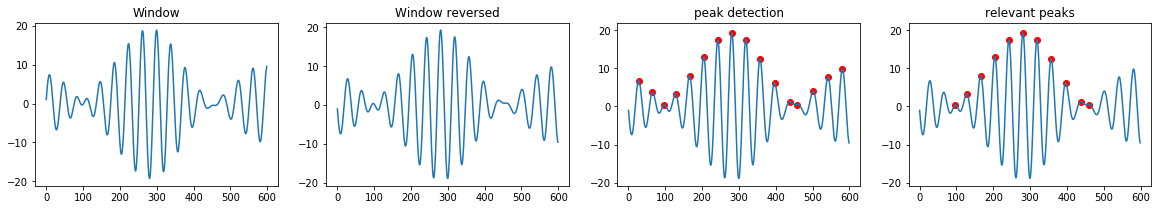

In [9]:
plt.clf()
window = eeg_signals_filt_nan[3][2188528 - 300 : 2188528 + 300]

plt.figure(figsize = (20,3))
plt.subplot(1,4,1)
plt.plot(window)
plt.title('Window')

#C'est plus pratique d'avoir le spindle centré sur sa valeur absolue max:
if window[int(len(window)/2)] < np.max(-window[int(len(window)/2) - 20 : int(len(window)/2) + 20]):
    #Si la "pointe" du spindle est orienté vers le bas, on retourne la fenêtre. C'est le cas dans cet exemple
    window = -window 
    
plt.subplot(1,4,2)
plt.plot(window)
plt.title('Window reversed')

plt.subplot(1,4,3)
peaks, peak_properties = sg.find_peaks(window, height=0)
peak_heights = peak_properties['peak_heights']
plt.plot(window)
plt.scatter(peaks, peak_heights, color = 'r')
plt.title('peak detection')

plt.subplot(1,4,4)
wave_peaks, wave_heights = myAlgos.keepWavePeaks(peaks, peak_heights)
plt.plot(window)
plt.scatter(wave_peaks, wave_heights, color = 'r')
plt.title('relevant peaks')

plt.show()

On peut estimer la durée du spindle avec le nombre de points entre les deux crêtes extrêmes.

En l'occurrence :

Cela permet d'éliminer les spindles qui auraient une durée > 2s ou < 0.5s.

Après cela, j'effectue une série de calculs et de condtions sur les crêtes obtenues afin de vérifier les points suivants :
- Le spindle est-il à peu près symétrique ?
- Est-ce qu'il a un bien une faible amplitude aux extrémités ?
- Est-ce que la durée du spindle est comprise entre 0.5s et 2s ?

Dans notre exemple :

In [10]:
print(' - Symétrique : ' + str(myAlgos.isSymmetric(wave_heights)))
print(' - Faible amplitude aux extrémités : ' + str(not myAlgos.isTooHigh(wave_heights)))
print(' - Durée spindle = ' + str(myAlgos.waveLength(wave_peaks)) + 's')

 - Symétrique : True
 - Faible amplitude aux extrémités : True
 - Durée spindle = 1.8s


#### En résumé :

1. Application d'un filtre passe-bande 11-15Hz
2. Nettoyage des points avec une très haute amplitude
3. Analyse par epoch de 5s
4. Si seuil dépassé : fenêtre autour de la valeur max de l'epoch
5. Détection de crête + conservation des crêtes propres au spindle
6. Conditions diverses sur les crêtes : symétrie, amplitude, durée du spindle
7. Si tout est validé, ajout de la position, durée et amplitude du spindle dans des listes.

Appliquons l'algorithme à l'ensemble des données.

In [18]:
importlib.reload(myAlgos)
spindles_detected = 0
spindles_positions = [None] * n_days
spindles_heights = [None] * n_days
spindles_length = [None] * n_days

fails = np.array([0,0,0,0,0,0])
for i in range(n_days): #Parcours par jour
    spindles_positions[i] = []
    spindles_heights[i] = []
    spindles_length[i] = []
    for j in range(epochs_filt_nan[i].shape[0]): #Parcours par epoch
        if j == 0: continue #petit probleme au tout debut a cause d'artefacts
        current_epoch = epochs_filt_nan[i][j]
        if (not myAlgos.nanFound(current_epoch)) and \
            myAlgos.threshold_reached(current_epoch) :
            
            # On se centre autour de la valeur max.
            # 600 points <=> 2.4 secondes
            max_pos = np.argmax(current_epoch)
            max_val = np.max(current_epoch)
            window = eeg_signals_filt_nan[i][j*n_pts_epochs + max_pos - 300 : j*n_pts_epochs + max_pos + 300]
            if not myAlgos.nanFound(window):    
                peaks, peak_properties = sg.find_peaks(window, height=0)
                peak_heights = peak_properties['peak_heights']
                if max_val == np.max(peak_heights) : #si rien de bizare lors du fenetrage
                    wave_peaks, wave_heights = myAlgos.keepWavePeaks(peaks, peak_heights)
                    if not myAlgos.isTooShort(wave_peaks) and not myAlgos.isTooLong(wave_peaks): #si 0.5s < x < 2s
                        if myAlgos.isSymmetric(wave_heights): #si les cretes sont symmetriques
                            if myAlgos.isTooHigh(wave_heights): #Si l'amplitude min n'est pas trop grande
                                spindles_detected += 1
                                spindles_positions[i].append(j*n_pts_epochs + max_pos)
                                spindles_heights[i].append(np.round(np.max(wave_heights),0))
                                spindles_length[i].append(myAlgos.waveLength(wave_peaks))
                            else :
                                fails[5] += 1
                                continue
                        else :
                            fails[4] += 1
                            continue
                    else :
                        fails[3] += 1
                        continue
                else : 
                    fails[2] += 1
                    continue
            else :
                fails[1] += 1
                continue
        else : 
            fails[0] += 1
            continue 
print('spindles détectées : ', spindles_detected)

spindles détectées :  3500


### Exemple de position des spindles sur une journée

Affichons la position des spindles sur tout le jour 3.

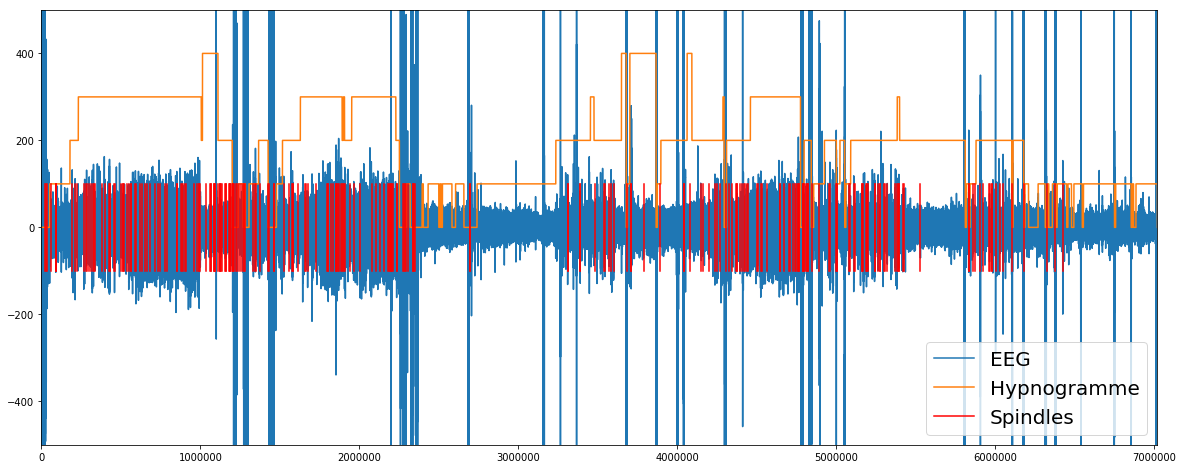

In [32]:
plt.clf()
plt.figure(figsize = (20,8))
plt.plot(eeg_signals[3])
plt.ylim(-500,500)
plt.xlim(-10,len(eeg_signals[3]))
plt.plot(hypnograms_long[3] * 100, color = 'C1')
for i in range(len(spindles_positions[3])):
    plt.axvline(x = spindles_positions[3][i], ymin = 0.4, ymax = 0.6, color = 'r')
plt.legend(['EEG', 'Hypnogramme', 'Spindles'], fontsize = 20, loc = 4)
plt.show()

## 2- Etude des propriétés des spindles

### Répartition des spindles par durée et amplitude

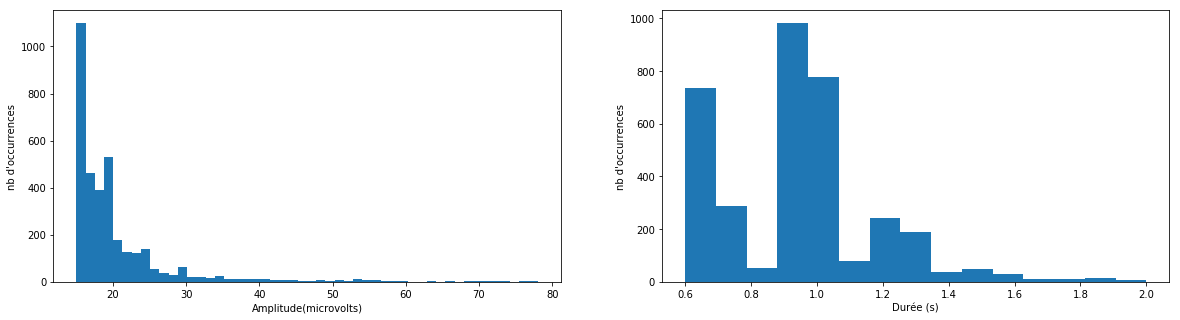

Amplitude moyenne des spindles : 20.6 +/- 8.5μV
Durée moyenne des spindles : 0.9 +/- 0.2s


In [70]:
plt.clf()
plt.figure(figsize = (20,5))

# Histogramme par amplitude
plt.subplot(1,2,1)
n, bins, patches = plt.hist(np.concatenate(spindles_heights), bins = 50)
plt.xlabel('Amplitude(microvolts)')
plt.ylabel("nb d'occurrences")

#Histogramme par durée
plt.subplot(1,2,2)
n, bins, patches = plt.hist(np.concatenate(spindles_length), bins = 15)
plt.xlabel('Durée (s)')
plt.ylabel("nb d'occurrences")

plt.show()

spindle_amp_mean = np.round(np.mean(np.concatenate(spindles_heights)),1)
spindle_amp_std = np.round(np.std(np.concatenate(spindles_heights)),1)
spindle_len_mean = np.round(np.mean(np.concatenate(spindles_length)),1)
spindle_len_std = np.round(np.std(np.concatenate(spindles_length)),1)
print('Amplitude moyenne des spindles : %s +/- %sμV'%(spindle_amp_mean, spindle_amp_std))
print('Durée moyenne des spindles : %s +/- %ss'%(spindle_len_mean, spindle_len_std))

Les spindles tendent à avoir une amplitude avoisinant les 20 microvolts et une durée proche de 1s.

### Répartition des spindles par stade de sommeil

In [37]:
stage = [0] * 5
for i in range(7):
    for pos in spindles_positions[i]:
        stage[int(hypnograms_long[i][pos])] += 1

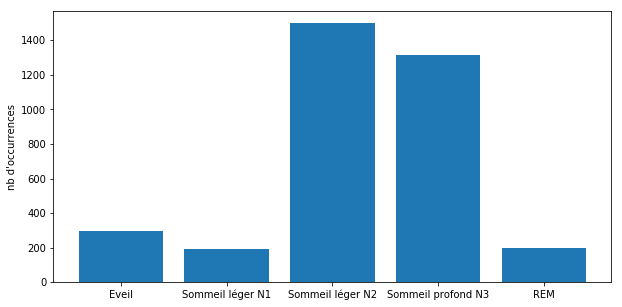

In [49]:
plt.clf()
plt.figure(figsize = (10,5))

# Histogramme par stade de sommeil
plt.bar(np.arange(5), stage)
plt.ylabel("nb d'occurrences")
plt.xticks(np.arange(5),('Eveil', 'Sommeil léger N1', 'Sommeil léger N2', 'Sommeil profond N3', 'REM'))
plt.show()

On constate que les spindles apparaissent majoritairement pendant le sommeil léger N2, et sont aussi très présents pendant le sommeil profond N3, et très peu présents dans les autres stades. Ce résultat se rapproche de ce qui est décrit dans le livre Understanding Sleep and Dreaming (p7, p19).

### Evolution de la densité de spindles par heure

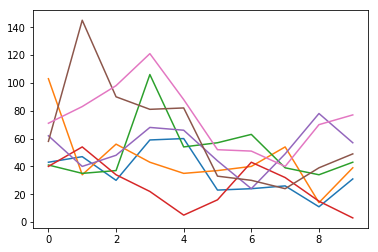

In [74]:
spindle_density = [None] * 7
for i in range(7):
    # Je sépare arbitrairement une nuit en 10 parties égales
    parts = 10
    l = len(eeg_signals[i])
    spindle_density[i] = np.zeros(parts)
    for j in range(10):
        temp = np.array(spindles_positions[i])
        bool_table = np.equal(temp < j*l/parts, temp > (j+1)*l/parts)
        spindle_density[i][j] = (sum(bool_table))

    plt.plot(spindle_density[i])
plt.show()

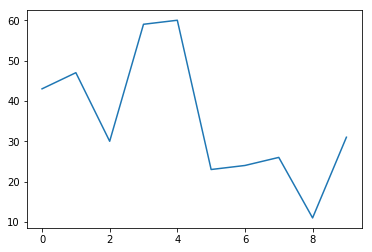

In [73]:
plt.clf()
plt.plot(spindle_density[0])
plt.show()